# Next Word Prediction Using Bidirectional LSTM 

In [1]:
import pandas as pd
import os
import numpy as np
!pip install tensorflow
import os
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# os.chdir('drive/My Drive/LSTM')

Mounted at /content/drive


In [3]:
class NextWordModel:
    """
    A class used to predict the next word(s)

    Attributes
    ----------
    next_words : int
        The number of words to predict
    model : 
        A model of type tensorflow.keras.models 
    normalizer: 
        A Hazm normalizer used to normalize seed text
    tokenizer:
        A tokenizer used in trainig phase and also used to tokenize seed text

    Methods
    -------
    predict(seed_text)
        Predicts next_words in given seed_text and returns a string
    """
    def __init__(self, next_words = 1):
        """
        Preparation steps

        """
        # specify number of next words to predict
        self.next_words = next_words
        
        # read data
        data = pd.read_csv('raw_data_for_next_word.csv')

        # only titles of data are used for training model
        # removing some unicodes
        data['title'] = data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
        data['title'] = data['title'].apply(lambda x: x.replace('\u200a',' '))
        
        # tokenizer definition
        self.tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
        self.tokenizer.fit_on_texts(data['title'])
        self.total_words = len(self.tokenizer.word_index) + 1
        
        input_sequences = []
        for line in data['title']:
            token_list = self.tokenizer.texts_to_sequences([line])[0]

            for i in range(1, len(token_list)):
                n_gram_sequence = token_list[:i+1]
                input_sequences.append(n_gram_sequence)

        # pad sequences
        self.max_sequence_len = max([len(x) for x in input_sequences])
        input_sequences = np.array(pad_sequences(input_sequences, maxlen=self.max_sequence_len, padding='pre'))

        # create features and label
        self.xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
        self.ys = tf.keras.utils.to_categorical(labels, num_classes=self.total_words)

    
    def train(self):
      """
        Trains Bidirectional LSTM on data used to next word prediction

      """
      # model definition and train
      self.model = Sequential()
      self.model.add(Embedding(self.total_words, 100, input_length=self.max_sequence_len-1))
      self.model.add(Bidirectional(LSTM(150)))
      self.model.add(Dense(self.total_words, activation='softmax'))
      adam = Adam(lr=0.01)
      self.model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
      self.history = self.model.fit(self.xs, self.ys, epochs=50, verbose=1)

      # save model
      self.model.save('model/model.h5')
    
    def predict(self, seed_text):
        """
        Predicts next_words in given seed_text and returns a string,

        Parameters
        ----------
        seed_text : str
            The text to used to make prediction

        Returns
        -------
        A string containing seed text and predicted next word(s)
        
        """
        for _ in range(self.next_words):
            token_list = self.tokenizer.texts_to_sequences([seed_text])[0]
            token_list = pad_sequences([token_list], maxlen=self.max_sequence_len-1, padding='pre')
            predict_x = self.model.predict(token_list, verbose=0) 
            predicted = np.argmax(predict_x,axis=1)

            output_word = ""
            for word, index in self.tokenizer.word_index.items():
                if index == predicted:
                    output_word = word
                    break
            seed_text += " " + output_word
        return seed_text
      
    def plot_graphs(self, param):
      """
        Plots graphs of model history parameters

        Parameters
        ----------
        history : 
            Model history
        param: string
            Model history parameter
        
        """
      plt.plot(self.history.history[param])
      plt.xlabel("Epochs")
      plt.ylabel(param)
      plt.show()



In [4]:
nwpModel = NextWordModel(next_words = 1)
nwpModel.train()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
1398/1398 [==============================] - 24s 12ms/step - loss: 8.0801 - accuracy: 0.0481
Epoch 2/50
1398/1398 [==============================] - 16s 11ms/step - loss: 6.9730 - accuracy: 0.0880
Epoch 3/50
1398/1398 [==============================] - 16s 11ms/step - loss: 5.5716 - accuracy: 0.1419
Epoch 4/50
1398/1398 [==============================] - 17s 12ms/step - loss: 4.2005 - accuracy: 0.2387
Epoch 5/50
1398/1398 [==============================] - 16s 11ms/step - loss: 3.2621 - accuracy: 0.3432
Epoch 6/50
1398/1398 [==============================] - 16s 12ms/step - loss: 2.6941 - accuracy: 0.4244
Epoch 7/50
1398/1398 [==============================] - 16s 11ms/step - loss: 2.4219 - accuracy: 0.4688
Epoch 8/50
1398/1398 [==============================] - 16s 11ms/step - loss: 2.1216 - accuracy: 0.5151
Epoch 9/50
1398/1398 [==============================] - 18s 13ms/step - loss: 1.9739 - accuracy: 0.5410
Epoch 10/50
1398/1398 [==============================] - 16s 11m

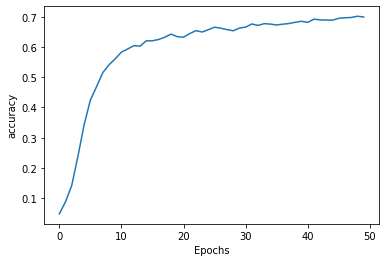

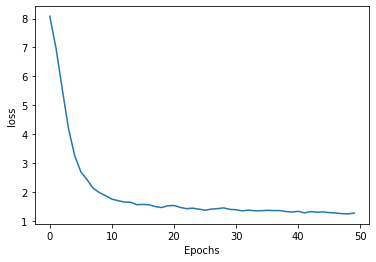

In [5]:
# plot accuracy and loss
nwpModel.plot_graphs('accuracy')
nwpModel.plot_graphs('loss')

In [6]:
nwpModel.predict("سازمان")

'سازمان صهیونیستی'

In [14]:
nwpModel.predict("اداره")

'اداره فرهنگ'

In [11]:
nwpModel.predict("تیم ملی")

'تیم ملی جوانان'